In [1]:
# ! git clone https://github.com/ClaudioPaterniti/MinesweeperLearning.git

In [2]:
#!pip install ipython-autotime
%load_ext autotime

time: 327 µs (started: 2024-10-26 23:38:31 +00:00)


In [3]:
import os
#os.chdir('/content/MinesweeperLearning')

time: 354 µs (started: 2024-10-26 23:38:31 +00:00)


In [4]:
import torch
import numpy as np

import src.utils as utils

from torch.utils.data import DataLoader

from src.models.patch_mlp import MineSweeperDataset, PatchMLPModel, Game
from src.player import Player, ThresholdPlayer

time: 1.66 s (started: 2024-10-26 23:38:31 +00:00)


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda
time: 20.3 ms (started: 2024-10-26 23:38:32 +00:00)


In [7]:
rng = np.random.default_rng()
patch_radius = 3
d = 2*patch_radius+1
layers=[2**i for i in range(9, 0, -1)]
name = f'patch_mlp_{d}x{d}_{layers[0]}_halving'
print(name)

model = PatchMLPModel(
    patch_radius,
    layers,
    ordinal_encoding = False,
    mine_rate_channel=True, device=device)
player = ThresholdPlayer(model, 0.05, 0.95)
optimizer = torch.optim.Adam(model.model.parameters(), lr=0.001)

patch_mlp_7x7_512_halving
time: 887 ms (started: 2024-10-26 23:38:32 +00:00)


In [ ]:
dataset = utils.sample(np.load('data/dataset.npy'), 200_000)

In [10]:
transform = model.transform
batch_size = 128
test_games = Game(n = 500)
zeros = test_games.open_zero()
training_data, test_data = torch.utils.data.random_split(MineSweeperDataset(dataset, transform), (0.95, 0.05))
train_dataloader = DataLoader(training_data, batch_size, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(training_data, batch_size, num_workers=4, pin_memory=True)

time: 580 ms (started: 2024-10-26 23:38:33 +00:00)


In [11]:
train_loss = []
test_loss = []
win_rate = []

time: 343 µs (started: 2024-10-26 23:38:34 +00:00)


In [12]:
epochs = 1
stop_if_no_max_after = 2
max_win_rate, argmax_t = 0, 0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(model.train(train_dataloader, optimizer))
    player.play(test_games)
    win_rate.append(test_games.win_rate())
    print(win_rate[-1])
    test_games.reset()
    test_games.open(zeros)
    test_loss.append(model.test(test_dataloader))
    if stop_if_no_max_after > 0:
      max_win_rate = max(max_win_rate, win_rate[-1])
      if win_rate[-1] > max_win_rate - 0.01:
        argmax_t = t
      elif t - argmax_t >= stop_if_no_max_after:
          break

Epoch 1
-------------------------------
0.0
time: 1min 51s (started: 2024-10-26 23:38:34 +00:00)


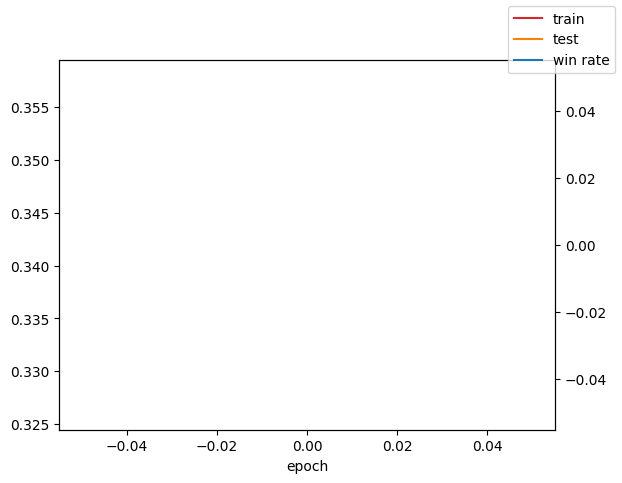

time: 403 ms (started: 2024-10-26 23:40:25 +00:00)


In [13]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')

ax1.plot(train_loss, color='tab:red', label = 'train')
ax1.plot(test_loss, color='tab:orange', label = 'test')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(win_rate, color=color, label = 'win rate')

fig.legend(loc="upper right")
plt.show()

In [14]:
model.save(os.path.join('weights', name + '.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '.opt'))

time: 47.1 ms (started: 2024-10-26 23:40:25 +00:00)


In [15]:
g = Game(16, 30, 99, n=1)
_ = g.open_zero()

time: 1.69 ms (started: 2024-10-26 23:40:26 +00:00)


[ True]
[False]


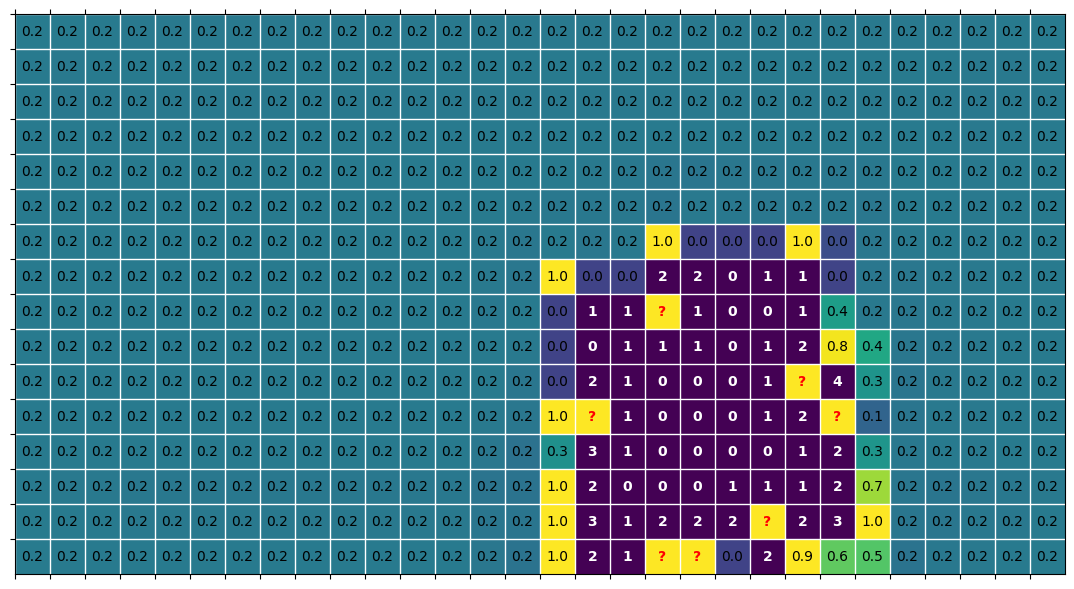

(<Axes: >,
 <matplotlib.image.AxesImage at 0x7d69e0091bd0>)

time: 1.02 s (started: 2024-10-26 23:40:26 +00:00)


In [16]:
player.play(g, 5)
print(g.active_games)
print(g.won)
p = model(g.game_state(), g.mines_n)
g.pyplot_game(0, mine_probs=p[0], highlighted='losing', print_zeros= True, size=0.35) # highlight newly opened in red

In [ ]:
reinforce_iterations = 5
epochs = 2
base_size, reinforce_size = 10_000, 10_000
losing_move_weight = 5
for i in range(reinforce_iterations):
  base = utils.sample(dataset, base_size)
  games = Game(16, 30, rng.normal(99, 30, reinforce_size).astype(int).clip(40, 160), reinforce_size)
  games.open_zero()
  player.play(games)
  data = np.concatenate([base, games.as_dataset()])
  weights = np.concatenate([np.ones_like(base), np.abs(games.losing_moves())*losing_move_weight])
  train_data = MineSweeperDataset(data, transform, weights)
  train_dataloader = DataLoader(train_data, batch_size, num_workers=4, pin_memory=True, shuffle=True)
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss.append(model.train(train_dataloader, optimizer))
      player.play(test_games)
      win_rate.append(test_games.win_rate())
      print(win_rate[-1])
      test_games.reset()
      test_games.open(zeros)
      test_loss.append(model.test(test_dataloader))

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')

ax1.plot(train_loss, color='tab:red', label = 'train')
ax1.plot(test_loss, color='tab:orange', label = 'test')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(win_rate, color=color, label = 'win rate')

fig.legend(loc="upper right")
plt.show()

In [ ]:
model.save(os.path.join('weights', name + '_reinforced.pth'))
torch.save(optimizer.state_dict(), os.path.join('weights', name + '_reinforced.opt'))